# Kinematics Assited Model Approach

Predict future position with forward kinematics and evaluate path with NN

In [167]:
training_dataset_root_path = "/home/michael/Desktop/BytesDB_simple2/"
validation_dataset_root_path = "/home/michael/Desktop/BytesDB_validation/"

In [168]:
import csv
import os
import math

class BytesDataset:
    def __init__(self,  root_path):
        self.root_path = root_path
        self.dataset_left_imgs = os.path.join(self.root_path, "left")
        self.dataset_right_imgs = os.path.join(self.root_path, "right")
        self.dataset_file = os.path.join(self.root_path, "db.csv")
        self._read_db_file()
        
    def get_index_map(self):
        return self.index_map
    
    def get_left_images_path(self):
        return self.dataset_left_imgs 
    
    def get_right_images_path(self):
        return self.dataset_right_imgs 
    
    def get_db(self):
        return self.db_file
    
    def get_episode_indices(self):
        return self.episode_indicies
    
    def get_drive_command(self, row):
        return [self.get_db_value(row, 'action x'), self.get_db_value(row, 'action r')]
    
    # untested
    def get_yaw(self, row):
        q = self.get_orientation(row) # z, y, x, w
        yaw = math.atan2(2.0*(q[1]*q[0] + q[3]*q[2]), q[3]*q[3] - q[2]*q[2] - q[1]*q[1] + q[0]*q[0])
        return yaw

    
    def get_position(self, row):
        return [self.get_db_value(row, 'position x'), self.get_db_value(row, 'position y'), self.get_db_value(row, 'position z')]
    
    def get_orientation(self, row):
        return [self.get_db_value(row, 'odom orientation z'), self.get_db_value(row, 'odom orientation y'), self.get_db_value(row, 'odom orientation x'), self.get_db_value(row, 'odom orientation w')]
    
    def get_db_value(self, row, column):
        if type(column) == str:
            column = self.index_map[column]
        if column:
            return float(self.db_file[row][column])
        else: 
            return self.db_file[row][column]
    
    def _read_db_file(self):
        # Read the db file
        self.db_file = []
        # start and stops for each episode (zero to be replaced later) [inclusive, exclusive]
        self.episode_indicies = [[1,0]] 
        with open(self.dataset_file) as file:
            csv_reader = csv.reader(file)
            for i, row in enumerate(csv_reader):
                if(row[0] == "-"):
                    self.episode_indicies.append([i+1,0])
                    self.episode_indicies[len(self.episode_indicies)-2][1] = i
                self.db_file.append(row)
            if self.episode_indicies[len(self.episode_indicies)-1][1] == 0:
                self.episode_indicies[len(self.episode_indicies)-1][1] = len(self.db_file)
        self.index_map = dict(zip(self.db_file[0],range(len(self.db_file[0]))))
        
validation_data = BytesDataset(validation_dataset_root_path)
train_data = BytesDataset(training_dataset_root_path) 

print("Size of training set: ", len(train_data.get_db()))
print("Size of validation set: ", len(validation_data.get_db()))

Size of training set:  405
Size of validation set:  7910


In [169]:
train_data.episode_indicies

[[1, 405]]

In [170]:
def quaternion_mult(q,r):
    return [r[0]*q[0]-r[1]*q[1]-r[2]*q[2]-r[3]*q[3],
            r[0]*q[1]+r[1]*q[0]-r[2]*q[3]+r[3]*q[2],
            r[0]*q[2]+r[1]*q[3]+r[2]*q[0]-r[3]*q[1],
            r[0]*q[3]-r[1]*q[2]+r[2]*q[1]+r[3]*q[0]]

# input point is [x,y,z] and quaternion is z, x, y, w
def point_rotation_by_quaternion(point,q):
    r = [0]+point
    q_conj = [q[0],-1*q[1],-1*q[2],-1*q[3]]
    return quaternion_mult(quaternion_mult(q,r),q_conj)[1:]

# point 1 - point 2
def subtract_points(point1, point2):
    return [point1[0] - point2[0], point1[1] - point2[1], point1[2] - point2[2]]

In [202]:
def pose_in_new_coordinate_space(start_index, target_index):
#     transformed_point = point_rotation_by_quaternion(point_rotation_by_quaternion(subtract_points( train_data.get_position(target_index),  train_data.get_position(start_index)), train_data.get_orientation(start_index)), [-0.707,0,0,0.707])
    transformed_point = point_rotation_by_quaternion(subtract_points( train_data.get_position(start_index),  train_data.get_position(target_index)), train_data.get_orientation(start_index))
    return [transformed_point[1], transformed_point[0]]

In [219]:
path_x = []
path_y = []
start_index = 1
for i in range(404):
    point = pose_in_new_coordinate_space(start_index, start_index+i)
    path_x.append(-point[0])
    path_y.append(point[1])

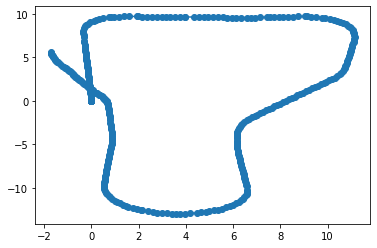

In [220]:
import matplotlib.pyplot as plt
plt.scatter(path_x, path_y)
plt.plot(path_x, path_y)
plt.show()

## Prediction

In [230]:
# questionable dt, the one corresponsing with the sleep time seems much more correct
avg_dt = 0
for i in range(240,300):
    avg_dt += train_data.get_db_value(i,'dt')
print(avg_dt/60)

0.3849833448727786


In [228]:
# negative r is right
path_x_est = [0]
path_y_est = [0]

last_pose = [0,0,0] # x,y,yaw
for i in range(1,404):
    command = train_data.get_drive_command(i)
#     dt = train_data.get_db_value(i, 'dt')
    dt = 0.2
    
    yaw = last_pose[2] + command[1]*dt
    x = last_pose[0] + command[0]*dt*math.sin(yaw)
    y = last_pose[1] + command[0]*dt*math.cos(yaw)
    
    last_pose = [x,y,yaw]
    
    path_x_est.append(-x)
    path_y_est.append(y)

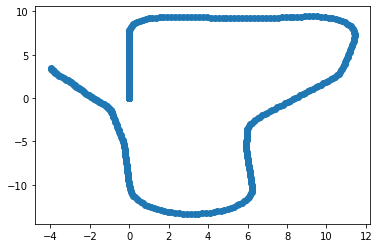

In [229]:
import matplotlib.pyplot as plt
plt.scatter(path_x_est, path_y_est)
plt.plot(path_x_est, path_y_est)
plt.show()